In [1]:
!pip install stochastic -q
!pip install -q tensorflow==2.8.0 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.12.1 which is incompatible.
tensorflow-decision-forests 1.5.0 requires tensorflow~=2.13.0, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-serving-api 2.13.0 requires tensorflow<3,>=2.13.0, but you have tensorflow 2.8.0 which is incompatible.
tensorflow-text 2.13.0 requires tensorflow<2.14,>=2.13.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.8.0 which is incompatible.
tensorflowjs 4.14.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.14.0 requires tensorflow<3,>=2.13.0, but you have tensorflow 2.8.0 which is incompatible.


# A TensorFlow-Based Differentiable TA-MSD Layer with correction for Estimating Anomalous Diffusion Exponents

Our contributions are as follows:

1.	Implementation of a Differentiable TA-MSD Layer: We propose a ready-to-use, non-trainable TensorFlow layer (which can potentially be implemented in any deep learning framework) that implements the TA-MSD method for estimating the anomalous diffusion exponent of particles (Algorithm 1). Notably, despite incorporating an algorithm to determine the slope of the fitting line, the layer remains fully differentiable. This ensures seamless integration with deep neural network architectures, allowing for end-to-end training and optimization.
  
2.	Variance-Based Ensemble Estimation: For an ensemble of particles with identical characteristics, the variance of the anomalous diffusion exponent estimates can be theoretically predicted. If the observed variance of the ensemble estimates closely matches the theoretical prediction, we propose confidently replacing each trajectory's individual estimate with the ensemble's average anomalous diffusion exponent.

  
3.	Bias Correction in Short Trajectories: In scenarios involving normal and superdiffusion, especially with short trajectories, non-ergodicity can lead to biased or inconsistent estimates of the diffusion exponent. We address this by implementing correction mechanisms that adjust results, ensuring more accurate and representative characterizations of the diffusion behavior.

4.	Adaptability to Segmented Trajectories with NAN values: Our TensorFlow layer is designed to be versatile, enabling the estimation of anomalous diffusion exponents for trajectory segments obtained after partitioning heterogeneous trajectories into homogeneous segments. This adaptability is achieved by allowing input data to contain NaN values in regions that should not be considered during the estimation (e.g., segments of different origins that do not belong to the homogeneous parts). The layer seamlessly ignores these NaN values when calculating the exponents, effectively focusing only on the valid parts of the trajectory. Furthermore, if a trajectory lacks a continuous, non-NaN segment of length equal to or greater than the maximum lag, the output for that trajectory will be set to NaN. 


In [2]:
import sys
sys.path.append('/kaggle/input/randimodel/randi-main')  

In [3]:
import numpy as np
import tensorflow as tf

class TAMSDalpha(tf.keras.layers.Layer):
    def __init__(self, use_correction=True, trim_percent=0, **kwargs):
        """
        Initialization of the TAMSDalpha layer.

        Args:
            use_correction (bool): Whether to apply normalization correction. Default is True.
            trim_percent (int): Percentage of highest values to trim. Default is 0.
        """
        super(TAMSDalpha, self).__init__(**kwargs)
        self.use_correction = use_correction
        self.trim_percent = trim_percent

    @staticmethod
    def nanmean(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanmean, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the mean.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Mean value with NaNs ignored.
        """
        mask = ~tf.math.is_nan(tensor)
        masked_tensor = tf.where(mask, tensor, tf.zeros_like(tensor))
        count = tf.reduce_sum(tf.cast(mask, tf.float32), axis=axis, keepdims=keepdims)
        sum_ = tf.reduce_sum(masked_tensor, axis=axis, keepdims=keepdims)
        return sum_ / (count + 1e-8)

    @staticmethod
    def nanstd(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanstd, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the standard deviation.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Standard deviation with NaNs ignored.
        """
        mean_ = TAMSDalpha.nanmean(tensor, axis=axis, keepdims=True)
        sq_diff = tf.square(tensor - mean_)
        var_ = TAMSDalpha.nanmean(sq_diff, axis=axis, keepdims=keepdims)
        return tf.sqrt(var_ + 1e-8)

    @staticmethod
    def trim_array1s(arr, percent):
        """
        Removes a given percentage of the largest values from each row of a 2D tensor, ignoring NaNs.
        
        Args:
            arr (tf.Tensor): Input 2D tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        def trim_row(row):
            valid = ~tf.math.is_nan(row)
            valid_values = tf.boolean_mask(row, valid)
            n_valid = tf.shape(valid_values)[0]
            
            def no_valid():
                return row
            
            def do_trim():
                k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
                k = tf.cast(tf.round(k_float), tf.int32)
                
                def no_trim():
                    return row
                
                def trim_values():
                    # Sort valid (non-NaN) values in ascending order
                    sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                    # Threshold is the k-th largest value
                    threshold = sorted_valid[-k]
                    # Keep values below threshold, replace others with NaN
                    return tf.where(row < threshold, row, tf.constant(np.nan, dtype=row.dtype))
                
                return tf.cond(tf.equal(k, 0), no_trim, trim_values)
            
            return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)
        
        return tf.map_fn(trim_row, arr)

    @staticmethod
    def trim_array1s_tea(arr, percent):
        """
        Removes a given percentage of the largest values from the entire tensor, ignoring NaNs.
        The number of elements to remove is based on all non-NaN values.

        Args:
            arr (tf.Tensor): Input tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        valid = ~tf.math.is_nan(arr)
        valid_values = tf.boolean_mask(arr, valid)
        n_valid = tf.shape(valid_values)[0]
        
        def no_valid():
            return arr
        
        def do_trim():
            k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
            k = tf.cast(tf.round(k_float), tf.int32)
            
            def no_trim():
                return arr
            
            def trim_values():
                sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                threshold = sorted_valid[-k]
                return tf.where(arr < threshold, arr, tf.constant(np.nan, dtype=arr.dtype))
            
            return tf.cond(tf.equal(k, 0), no_trim, trim_values)
        
        return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)

    def tf_normalize_distribution(self, arr, target_mean, T):
        """
        Normalize the distribution with correction.

        Args:
            arr (tf.Tensor): Input array.
            target_mean (tf.Tensor): Target mean value.
            T (tf.Tensor): Effective time/count indicator.

        Returns:
            tf.Tensor: Normalized array.
        """
        current_mean = self.nanmean(arr)
        current_std = self.nanstd(arr)
        adjustment_term = tf.maximum(current_std**2 - 0.92 / T, 0)**0.5
        standardized = (arr - current_mean) / (current_std + 1e-8)
        return standardized * adjustment_term + target_mean

    def call(self, inputs):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, timesteps, input_channels).

        Returns:
            tf.Tensor: Estimated alpha values.
        """
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]
        input_channels = tf.shape(inputs)[2]

        # Count non-NaN elements across the batch
        not_nan_mask = ~tf.math.is_nan(inputs)
        not_nan_count = tf.reduce_sum(tf.cast(not_nan_mask, tf.float32))

        epsilon = 1e-14
        x_all = inputs
        max_lag = 4
        msds = []
        teamsd_list = []

        # --- Compute MSD and TEA-MSD ---
        for lag in range(1, max_lag + 1):
            displacements = x_all[:, lag:, :] - x_all[:, :-lag, :]
            squared_displacements = tf.square(displacements)
            squared_displacements_sum = tf.reduce_sum(squared_displacements, axis=2)

            # For MSD – trim each row
            msd = self.nanmean(
                self.trim_array1s(squared_displacements_sum, self.trim_percent),
                axis=1
            )
            msds.append(msd)

            # For TEA-MSD – trim the array as a whole
            teamsd_lag = self.nanmean(
                self.trim_array1s_tea(squared_displacements_sum, self.trim_percent)
            )
            teamsd_list.append(teamsd_lag)

        msds = tf.stack(msds, axis=1)             # (batch_size, max_lag)
        teamsd = tf.stack(teamsd_list, axis=0)    # (max_lag,)

        t_lags = tf.range(1, max_lag + 1, dtype=tf.float32)
        log_t_lags = tf.math.log(t_lags + epsilon)

        # --- Compute TEA-MSD alpha ---
        log_teamsd = tf.math.log(teamsd + epsilon)
        mean_x = self.nanmean(log_t_lags)
        mean_x2 = self.nanmean(tf.square(log_t_lags))
        mean_y_teamsd = self.nanmean(log_teamsd)
        mean_xy_teamsd = self.nanmean(log_t_lags * log_teamsd)

        numerator_teamsd = mean_xy_teamsd - mean_x * mean_y_teamsd
        denominator = mean_x2 - mean_x**2
        alpha_teamsd = numerator_teamsd / denominator

        # --- Compute alpha for the batch ---
        log_msds = tf.math.log(msds + epsilon)   # (batch_size, max_lag)
        mean_y = self.nanmean(log_msds, axis=1)   # (batch_size,)
        mean_xy = self.nanmean(log_t_lags * log_msds, axis=1)
        numerator = mean_xy - mean_x * mean_y
        alpha = numerator / denominator           # (batch_size,)

        # --- Replace alpha with NaN if the last MSD < 1e-6 ---
        last_msd = msds[:, -1]  # (batch_size,)
        mask_nan = last_msd < 1e-6
        alpha = tf.where(mask_nan, tf.fill(tf.shape(alpha), np.nan), alpha)

        # --- Compute T based on the number of valid trajectories ---
        valid_mask = ~mask_nan
        valid_count = tf.reduce_sum(tf.cast(valid_mask, tf.float32))
        T = not_nan_count / (valid_count * tf.cast(input_channels, tf.float32))

        # --- Apply normalization correction if enabled ---
        if self.use_correction:
            alpha = self.tf_normalize_distribution(alpha, alpha_teamsd, T)

        # --- Clip alpha to the valid range ---
        alpha = tf.clip_by_value(alpha, clip_value_min=0.0001, clip_value_max=1.999)

        return alpha


## Code to compare results against the Whittle method and the standard TA-MSD method

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from utils import data_norm, data_reshape, many_net_uhd, my_atan
randi25 = load_model('/kaggle/input/randimodel/randi-main/nets/inference_nets/2d/inference_2D_25.h5')
randi65 = load_model('/kaggle/input/randimodel/randi-main/nets/inference_nets/2d/inference_2D_65.h5') 

In [5]:

#  from https://github.com/AnDiChallenge/
import numpy as np
import pandas as pd
from stochastic.processes.noise import FractionalGaussianNoise as FGN
import warnings
import scipy.stats
def gaussian(params:list|int, # If list, mu and sigma^2 of the gaussian. If int, we consider sigma = 0
             size = 1,  # Number of samples to get.
             bound = None # Bound of the Gaussian, if any.
            )-> np.array: # Samples from the given Gaussian distribution
    '''
    Samples from a Gaussian distribution of given parameters.
    '''
    # if we are given a single number, we consider equal to mean and variance = 0
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)
    else:
        mean, var = params        
        if bound is None:
            val = np.random.normal(mean, np.sqrt(var), size)
        if bound is not None:
            lower, upper = bound
            if var == 0: 
                if mean > upper or mean < lower:
                    raise ValueError('Demanded value outside of range.')
                val = np.ones(size)*mean
            else:
                val = scipy.stats.truncnorm.rvs((lower-mean)/np.sqrt(var),
                                                (upper-mean)/np.sqrt(var),
                                                loc = mean,
                                                scale = np.sqrt(var),
                                                size = size)
        if size == 1:
            return val[0]
        else:
            return val


In [6]:
# Dataset generration from https://github.com/AnDiChallenge/

# %% ../source_nbs/lib_nbs/models_phenom.ipynb 5
class models_phenom():
    def __init__(self):
        '''
        This class handles the generation of trajectories from different theoretical models. 
        ''' 
        # We define here the bounds of the anomalous exponent and diffusion coefficient
        self.bound_D = [1e-12, 1e6]
        self.bound_alpha = [0, 1.999]
        
        # We also define the value in which we consider directed motion
        self.alpha_directed = 1.9
        
        # Diffusion state labels: the position of each type defines its numerical label
        # i: immobile/trapped; c: confined; f: free-diffusive (normal and anomalous); d: directed
        self.lab_state = ['i', 'c', 'f', 'd']

# %% ../source_nbs/lib_nbs/models_phenom.ipynb 7
class models_phenom(models_phenom):
    
    @staticmethod
    def disp_fbm(alpha : float,
                 D : float,
                 T: int, 
                 deltaT : int = 1):
        ''' Generates normalized Fractional Gaussian noise. This means that, in 
        general:
        $$
        <x^2(t) > = 2Dt^{alpha}
        $$
                            
        and in particular:
        $$
        <x^2(t = 1)> = 2D 
        $$
        
        Parameters
        ----------
        alpha : float in [0,2]
            Anomalous exponent
        D : float
            Diffusion coefficient
        T : int
            Number of displacements to generate
        deltaT : int, optional
            Sampling time
            
        Returns
        -------
        numpy.array
            Array containing T displacements of given parameters
        
        '''
        
        # Generate displacements
        disp = FGN(hurst = alpha/2).sample(n = T)
        # Normalization factor
        disp *= np.sqrt(T)**(alpha)
        # Add D
        disp *= np.sqrt(2*D*deltaT)        
        
        return disp

# %% ../source_nbs/lib_nbs/models_phenom.ipynb 18
class models_phenom(models_phenom):
    
    @staticmethod
    def _constraint_alpha(alpha_1, alpha_2, epsilon_a):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        return alpha_1 - alpha_2 < epsilon_a
    
    @staticmethod
    def _constraint_d(d1, d2, gamma_d):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        if gamma_d < 1:
            return d2 > d1*gamma_d
        if gamma_d > 1:
            return d2 < d1*gamma_d
    
    @staticmethod
    def _sample_diff_parameters(alphas : list, # List containing the parameters to sample anomalous exponent in state (adapt to sampling function)
                                Ds : list, # List containing the parameters to sample the diffusion coefficient in state (adapt to sampling function).
                                num_states : int, # Number of diffusive states.
                                epsilon_a : float, #  Minimum distance between anomalous exponents of various states.
                                gamma_d : float, # Factor between diffusion coefficient of various states.
                               ) : 
        '''    
        Given information of the anomalous exponents (alphas), diffusion coefficients (Ds), the function
        samples these from a bounded Gaussian distribution with the indicated constraints (epsilon_a,
        gamma_d). Outputs the list of demanded alphas and Ds.
        
        
        Parameters
        ----------
        alphas : list
        List containing the parameters to sample anomalous exponent in state (adapt to sampling function).
        Ds : list
        List containing the parameters to sample the diffusion coefficient in state (adapt to sampling function).
        num_states : int
        Number of diffusive states.
        epsilon_a : float
        Minimum distance between anomalous exponents of various states.            
                epsilon workflow: we check val[i] - val[i-1] < epsilon
                    if you want that val[i] > val[i-1]: epsilon has to be positive
                    if you want that val[i] < val[i-1]: epsilon has to be negative
                    if you don't care: epsilon = 0
                
        gamma_d : float
        Factor between diffusion coefficient of various states.            
                gamma workflow: 
                    for gamma < 1: val[i] < val[i-1]*gamma
                    for gamma > 1: val[i] > val[i-1]*gamma
                    for gamma = 1: no check
        Returns
        -------
            :alphas_traj (list): list of anomalous exponents
            :Ds_traj (list): list of diffusion coefficients
                      
        '''

        
        alphas_traj = []
        Ds_traj = []
        for i in range(num_states): 

            # for the first state we just sample normally
            if i == 0:
                alphas_traj.append(float(gaussian(alphas[i], bound = models_phenom().bound_alpha)))
                Ds_traj.append(float(gaussian(Ds[i], bound = models_phenom().bound_D)))
           
            # For next states we take into account epsilon distance between diffusion
            # parameter
            else:
                ## Checking alpha
                alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))
                D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))

                if epsilon_a[i-1] != 0:
                    idx_while = 0
                    while models_phenom()._constraint_alpha(alphas_traj[-1], alpha_state, epsilon_a[i-1]):
                    #alphas_traj[-1] - alpha_state < epsilon_a[i-1]:
                        alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))                        
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct alpha for state {i} in 100 steps. State distributions probably too close.')

                alphas_traj.append(alpha_state)
                
                ## Checking D
                if gamma_d[i-1] != 1:    
                    
                    idx_while = 0
                    while models_phenom()._constraint_d(Ds_traj[-1], D_state, gamma_d[i-1]):
                        D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct D for state {i} in 100 steps. State distributions probably too close.')
               
    
                Ds_traj.append(D_state)
                
        return alphas_traj, Ds_traj

# %% ../source_nbs/lib_nbs/models_phenom.ipynb 26
class models_phenom(models_phenom):
    
    @staticmethod
    def _single_state_traj(T :int = 200, 
                          D : float = 1, 
                          alpha : float = 1, 
                          L : float = None,
                          deltaT : int = 1,
                          dim : int = 2):
        '''
        Generates a single state trajectory with given parameters. 
        
        Parameters
        ----------
        T : int
            Length of the trajectory
        D : float
            Diffusion coefficient       
        alpha : float
            Anomalous exponent
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time
        dim : int
            Dimension of the walk (can be 2 or 3)
            
        Returns
        -------
        tuple
            - pos: position of the particle
            - labels:  anomalous exponent, D and state at each timestep. State is always free here.
            
        '''
        
        
        # Trajectory displacements
        disp_d = []
        for d in range(dim):
            disp_d.append(models_phenom().disp_fbm(alpha, D, T))
        # Labels
        lab_diff_state = np.ones(T)*models_phenom().lab_state.index('f') if alpha < models_phenom().alpha_directed else np.ones(T)*models_phenom().lab_state.index('d')
        labels = np.vstack((np.ones(T)*alpha, 
                            np.ones(T)*D,
                            lab_diff_state
                           )).transpose()

        # If there are no boundaries
        if not L:
            
            pos = np.vstack([np.cumsum(disp)-disp[0] for disp in disp_d]).transpose()
            
            return pos, labels

        # If there are, apply reflecting boundary conditions
        else:
            pos = np.zeros((T, dim))

            # Initialize the particle in a random position of the box
            pos[0, :] = np.random.rand(dim)*L
            for t in range(1, T):
                if dim == 2:
                    pos[t, :] = [pos[t-1, 0]+disp_d[0][t], 
                                 pos[t-1, 1]+disp_d[1][t]]            
                elif dim == 3:
                    pos[t, :] = [pos[t-1, 0]+disp_d[0][t], 
                                 pos[t-1, 1]+disp_d[1][t], 
                                 pos[t-1, 2]+disp_d[2][t]]            


                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]

            return pos, labels

# %% ../source_nbs/lib_nbs/models_phenom.ipynb 33
class models_phenom(models_phenom):
    
    
    def single_state(self,
                     N:int = 10,
                     T:int = 200, 
                     Ds:list = [1, 0], 
                     alphas:list = [1, 0], 
                     L:float = None,
                     dim:int = 2):
        '''
        Generates a dataset made of single state trajectories with given parameters.
        
        Parameters
        ----------
        N : int, list
            Number of trajectories in the dataset
        T : int
            Length of the trajectory
        Ds : float
            If list, mean and variance from which to sample the diffusion coefficient. If float, we consider variance = 0.
        alphas : float
            If list, mean and variance from which to sample the anomalous exponent. If float, we consider variance = 0.
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time            
        dim : int
            Dimension of the walk (can be 2 or 3)
            
        Returns
        -------
        tuple
            - positions: position of the N trajectories.
            - labels:  anomalous exponent, D and state at each timestep. State is always free here.         
        '''

        positions = np.zeros((T, N, dim))
        labels = np.zeros((T, N, 3))

        for n in range(N):
            alpha_traj = gaussian(alphas, bound = self.bound_alpha)
            D_traj = gaussian(Ds, bound = self.bound_D)
            # Get trajectory from single traj function
            pos, lab = self._single_state_traj(T = T, 
                                               D = D_traj, 
                                               alpha = alpha_traj, 
                                               L = L,
                                               dim = dim
                                              )        
            positions[:, n, :] = pos
            labels[:, n, :] = lab

        return positions, labels


In [7]:
"""
This module have been implemented to compute an Hurst exponent
Estimator using maximum of likelyhood on the periodogram.
It is not a log regression as in Hest_Welp
the  periodogram is the one given by the scipy library
these functions hab been made according to whittlenew,
wittlefunc and fspecFGN of Matlab Biyu_code
"""
import numpy as np
import scipy.optimize as so
from math import gamma


def whittle(data):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_t(data, pointeur, idx):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    the return happend in pointeur[idx]
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    pointeur[idx] = so.fminbound(func, 0, 1)


def whittle_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on welch periodogram
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(dataidx))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_norm_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on periodogram
    the data are normalized which does'nt change anything !
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    datanorm = (dataidx - np.mean(dataidx)) / np.var(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(datanorm))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittlefunc(hurst, gammahat, nbpoints):
    """This is the Whittle function
    """
    gammatheo = fspec_fgn(hurst, nbpoints)
    qml = gammahat / gammatheo
    return 2 * (2 * np.pi / nbpoints) * np.sum(qml)


def fspec_fgn(hest, nbpoints):
    """This is the spectral density of a fGN of Hurst exponent hest
    """
    hhest = - ((2 * hest) + 1)
    const = np.sin(np.pi * hest) * gamma(- hhest) / np.pi
    nhalfm = int((nbpoints - 1) / 2)
    dpl = 2 * np.pi * np.arange(1, nhalfm + 1) / nbpoints
    fspec = np.ones(nhalfm)
    for i in np.arange(0, nhalfm):
        dpfi = np.arange(0, 200)
        dpfi = 2 * np.pi * dpfi
        fgi = (np.abs(dpl[i] + dpfi)) ** hhest
        fhi = (np.abs(dpl[i] - dpfi)) ** hhest
        dpfi = fgi + fhi
        dpfi[0] = dpfi[0] / 2
        dpfi = (1 - np.cos(dpl[i])) * const * dpfi
        fspec[i] = np.sum(dpfi)
    fspec = fspec / np.exp(2 * np.sum(np.log(fspec)) / nbpoints)
    return fspec

In [8]:
import numpy as np

class ta_msd:
    def __init__(self):
        """Contains mean squared displacement (MSD)–based methods for trajectory analysis."""
        pass

    def trim_array1s(self, arr, percent=0):
        """
        Removes a given percentage of the largest values from each row of the array, ignoring NaNs.
        
        Parameters:
            arr (numpy.ndarray): Input data array.
            percent (float): Percentage of the largest values to remove in each row (0 <= percent < 100).
        
        Returns:
            numpy.ndarray: Array with the largest values in each row replaced by NaN.
        """
        if not (0 <= percent < 100):
            raise ValueError("Parameter 'percent' must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if arr.size == 0:
            return np.array([])  # Return an empty array if input is empty
        
        result = np.empty_like(arr, dtype=float)
        
        for i, row in enumerate(arr):
            # Select only non-NaN values in the row
            non_nan_values = row[~np.isnan(row)]
            
            if non_nan_values.size == 0:
                # If the row contains only NaNs, leave it unchanged
                result[i] = row
                continue
            
            # Sort non-NaN values in ascending order
            sorted_values = np.sort(non_nan_values)
            
            # Determine number of elements to remove
            n_non_nan = sorted_values.size
            k = int(np.ceil(percent / 100 * n_non_nan))
            
            if k == 0:
                # If nothing to remove, copy the row as is
                result[i] = row
                continue
            
            # Determine the threshold value for removal
            threshold = sorted_values[-k]
            
            # Mask values above the threshold and set them to NaN
            mask = row <= threshold
            result[i] = np.where(mask, row, np.nan)
        
        return result
    
    def trim_array1s_tea(self, arr, percent=15):
        """
        Removes a given percentage of the largest values from the entire array, ignoring NaNs.
        The count of elements to remove is based on all non-NaN values.
        
        Parameters:
            arr (numpy.ndarray): Input data array.
            percent (float): Percentage of the largest values to remove (0 <= percent < 100).
        
        Returns:
            numpy.ndarray: Array with the largest values replaced by NaN.
        """
        if not (0 <= percent < 100):
            raise ValueError("Parameter 'percent' must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if arr.size == 0:
            return np.array([])  # Return an empty array if input is empty
        
        # Flatten the array and ignore NaNs
        flattened = arr[~np.isnan(arr)]
        
        if flattened.size == 0:
            # If all values are NaN, return the original array
            return arr
        
        # Sort the non-NaN values
        sorted_values = np.sort(flattened)
        
        # Determine number of elements to remove
        n_non_nan = sorted_values.size
        k = int(np.ceil(percent / 100 * n_non_nan))
        
        if k == 0:
            # If nothing to remove, return the original array
            return arr
        
        # Determine the threshold value for removal
        threshold = sorted_values[-k]
        
        # Mask values above the threshold and set them to NaN
        mask = arr <= threshold
        result = np.where(mask, arr, np.nan)
        
        return result




    def tamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, D: dimension, T: lenght)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        tamsd = np.zeros((trajs.shape[0],len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632, axis=-1)
         
            res3 = np.nanmean(self.trim_array1s_tea(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15), axis=-1) * 1.664

            if method=='MSD':
                    tamsd[:,idx] = res1
            elif method=='MSDt':
                    tamsd[:,idx] = res3
            elif method=='MedianSD':
                    tamsd[:,idx] = res4            
            elif method=='QSD':
                    tamsd[:,idx] = res5     

        return tamsd
        
    def teamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, D: dimension, T: lenght)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        teamsd = np.zeros((1,len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632)
         
            res3 = np.nanmean(self.trim_array1s_tea(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15)) * 1.664

            if method=='MSD':
                    teamsd[:,idx] = res1
            elif method=='MSDt':
                    teamsd[:,idx] = res3
            elif method=='MedianSD':
                    teamsd[:,idx] = res4            
            elif method=='QSD':
                    teamsd[:,idx] = res5 
        return teamsd    

    def get_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags) 

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.polyfit(t_lags, row, deg = 1)[0] / 4
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res
    
    def get_tea_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags) 



        if not np.any(np.isnan(teasmd)):
            res = np.polyfit(t_lags, teasmd[0], deg = 1)[0] / 4
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res
        
    def get_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags, method)

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.clip(np.polyfit(np.log(t_lags), np.log(row), deg = 1)[0], 0.001, 1.999)
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res       

    def get_tea_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags, method)



        if not np.any(np.isnan(teasmd)):
            res = np.clip(np.polyfit(np.log(t_lags), np.log(teasmd[0]), deg = 1)[0], 0.001, 1.999)
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res

# Diffusion coefficient from N( D , 0 ) 

H = 0.01
H = 0.03
H = 0.05
H = 0.07
H = 0.09
H = 0.11
H = 0.13
H = 0.15
H = 0.17
H = 0.19
H = 0.21
H = 0.23
H = 0.25
H = 0.27
H = 0.29
H = 0.31
H = 0.33
H = 0.35
H = 0.37
H = 0.39
H = 0.41
H = 0.43
H = 0.45
H = 0.47
H = 0.49
H = 0.51
H = 0.53
H = 0.55
H = 0.57
H = 0.59
H = 0.61
H = 0.63
H = 0.65
H = 0.67
H = 0.69
H = 0.71
H = 0.73
H = 0.75
H = 0.77
H = 0.79
H = 0.81
H = 0.83
H = 0.85
H = 0.87
H = 0.89
H = 0.91
H = 0.93
H = 0.95
H = 0.97
H = 0.99


/tmp/ipykernel_19/493164756.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap   = plt.cm.get_cmap('tab10')


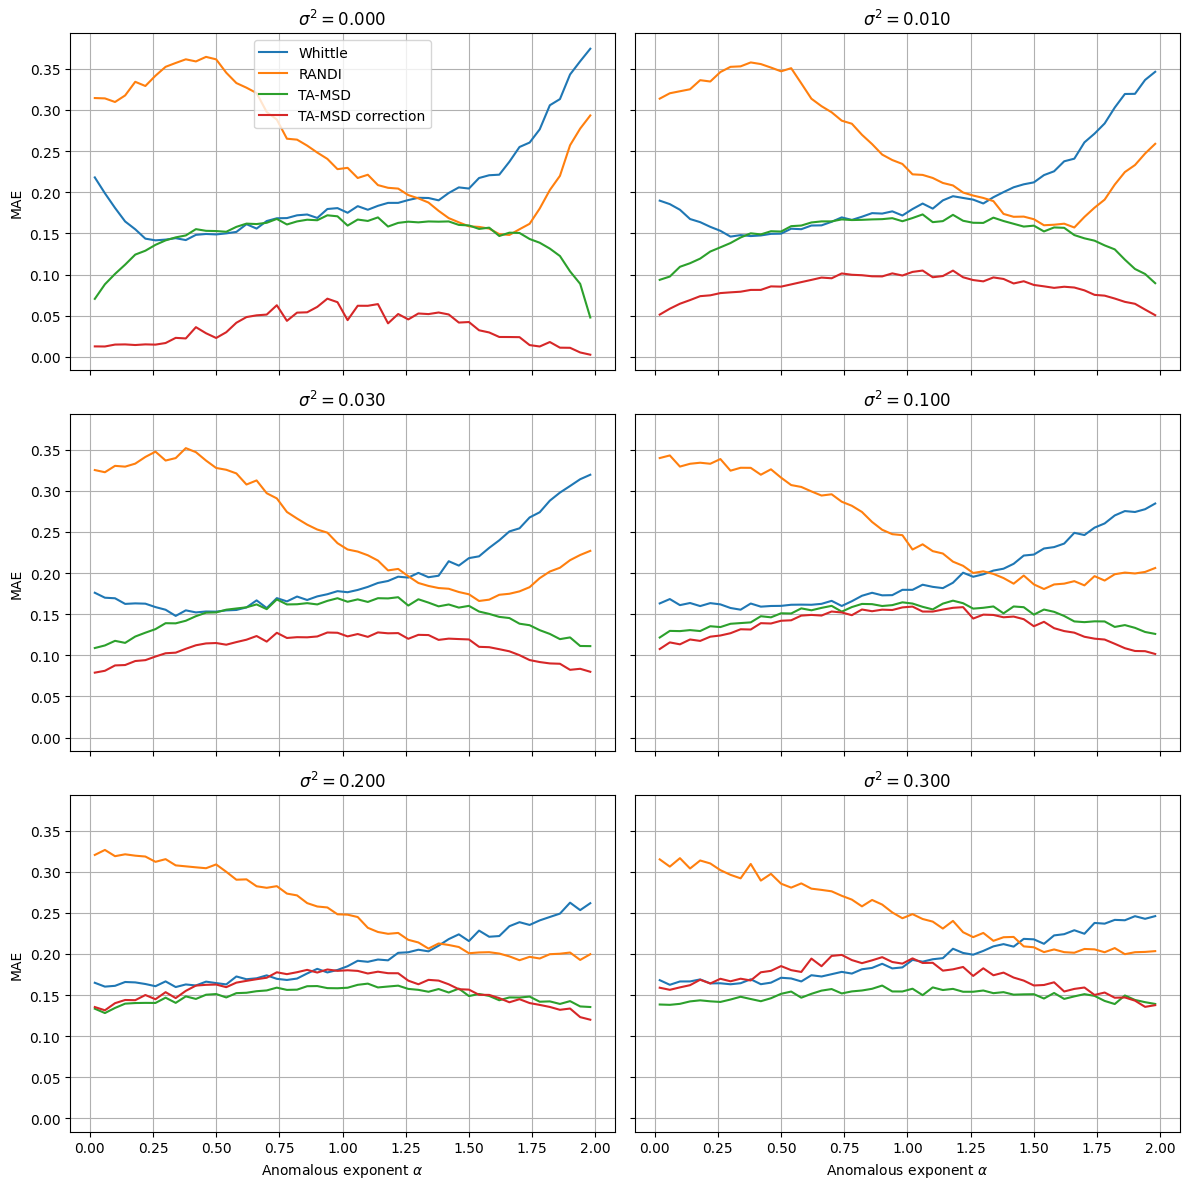

In [9]:
# ────────────────────── 1. Parameters ──────────────────────
HURST   = [i/100 for i in range(1, 100, 2)]          # 0.01 … 0.99
sigma   = [0, 0.01, 0.03, 0.1, 0.2, 0.3]          # 6 values of σ²
methods = ['Whittle', 'RANDI', 'TA-MSD', 'TA-MSD correction']

bs25    = randi25.layers[0].input_shape[-1]
T, N    = 25, 100                                # trajectory length

TFalpha      = TAMSDalpha(use_correction=False)  # TA-MSD
TFalphaTEA   = TAMSDalpha(use_correction=True)   # TA-MSD (correction)
models_class = models_phenom()

examples = 20        # ← now you can set any positive number

# ────────────────────── 2. Error array ──────────────────────
errs = np.zeros((len(sigma), len(HURST), len(methods)))

# ────────────────────── 3. Trajectory generation and MAE calculation ──────────────────────
for h_ind, hurst in enumerate(HURST):
    print(f'H = {hurst:.2f}')
    for _ in range(examples):
        D = 10**(np.random.random() * 12 - 6)                 # random diffusion coefficient
        
        for k, s2 in enumerate(sigma):
            cumts, lab = models_class.single_state(
                N=N, T=T, Ds=[D, 0], alphas=[hurst * 2, s2]
            )
            ts  = (cumts[1:] - cumts[:-1]).transpose(1, 0, 2)  # displacements
            lab = lab[0, :, 0]                                 # true α values
            cumts = cumts.transpose(1, 2, 0)                   # [traj, dim, t]
            
            # ── RANDI method ──
            data25    = data_norm(cumts, dim=2, task=1)
            data_rs25 = data_reshape(data25, bs=bs25, dim=2)
            pred_25   = randi25.predict(data_rs25).flatten()
            cumts = cumts.transpose(0, 2, 1)
            
            # ── MAE for the four methods ──────────────────────
            mae_whittle  = np.mean([
                np.abs((whittle(sp[:, 0]) + whittle(sp[:, 1])) - lab_i)
                for sp, lab_i in zip(ts, lab)
            ])
            mae_randi    = np.mean(np.abs(pred_25 - lab))
            mae_tf       = np.mean(np.abs(TFalpha(cumts).numpy() - lab))
            mae_tf_tea   = np.mean(np.abs(TFalphaTEA(cumts).numpy() - lab))
            
            # ⬇️ accumulate errors (NOTE: '+=')
            errs[k, h_ind, :] += [mae_whittle, mae_randi, mae_tf, mae_tf_tea]

# ⬇️ average over the number of runs
errs /= examples

# ────────────────────── 4. Plotting 6 graphs (3×2) ──────────────────────
cmap   = plt.cm.get_cmap('tab10')
colors = {m: cmap(i) for i, m in enumerate(methods)}

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (ax, s2) in enumerate(zip(axes, sigma)):
    for m in methods:
        m_idx = methods.index(m)
        ax.plot(
            np.array(HURST) * 2,
            errs[idx, :, m_idx],
            label=m if idx == 0 else None,
            color=colors[m]
        )
    
    ax.set_title(rf'$\sigma^2 = {s2:.3f}$')
    ax.grid(True)
    if idx % 2 == 0:
        ax.set_ylabel('MAE')
    if idx // 2 == 2:
        ax.set_xlabel(r'Anomalous exponent $\alpha$')

# display legend only once
axes[0].legend()
plt.tight_layout()
plt.show()


# Diffusion coefficient from N( D , D ) - very high variance

H = 0.01
H = 0.03
H = 0.05
H = 0.07
H = 0.09
H = 0.11
H = 0.13
H = 0.15
H = 0.17
H = 0.19
H = 0.21
H = 0.23
H = 0.25
H = 0.27
H = 0.29
H = 0.31
H = 0.33
H = 0.35
H = 0.37
H = 0.39
H = 0.41
H = 0.43
H = 0.45
H = 0.47
H = 0.49
H = 0.51
H = 0.53
H = 0.55
H = 0.57
H = 0.59
H = 0.61
H = 0.63
H = 0.65
H = 0.67
H = 0.69
H = 0.71
H = 0.73
H = 0.75
H = 0.77
H = 0.79
H = 0.81
H = 0.83
H = 0.85
H = 0.87
H = 0.89
H = 0.91
H = 0.93
H = 0.95
H = 0.97
H = 0.99


/tmp/ipykernel_19/1742920568.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap   = plt.cm.get_cmap('tab10')


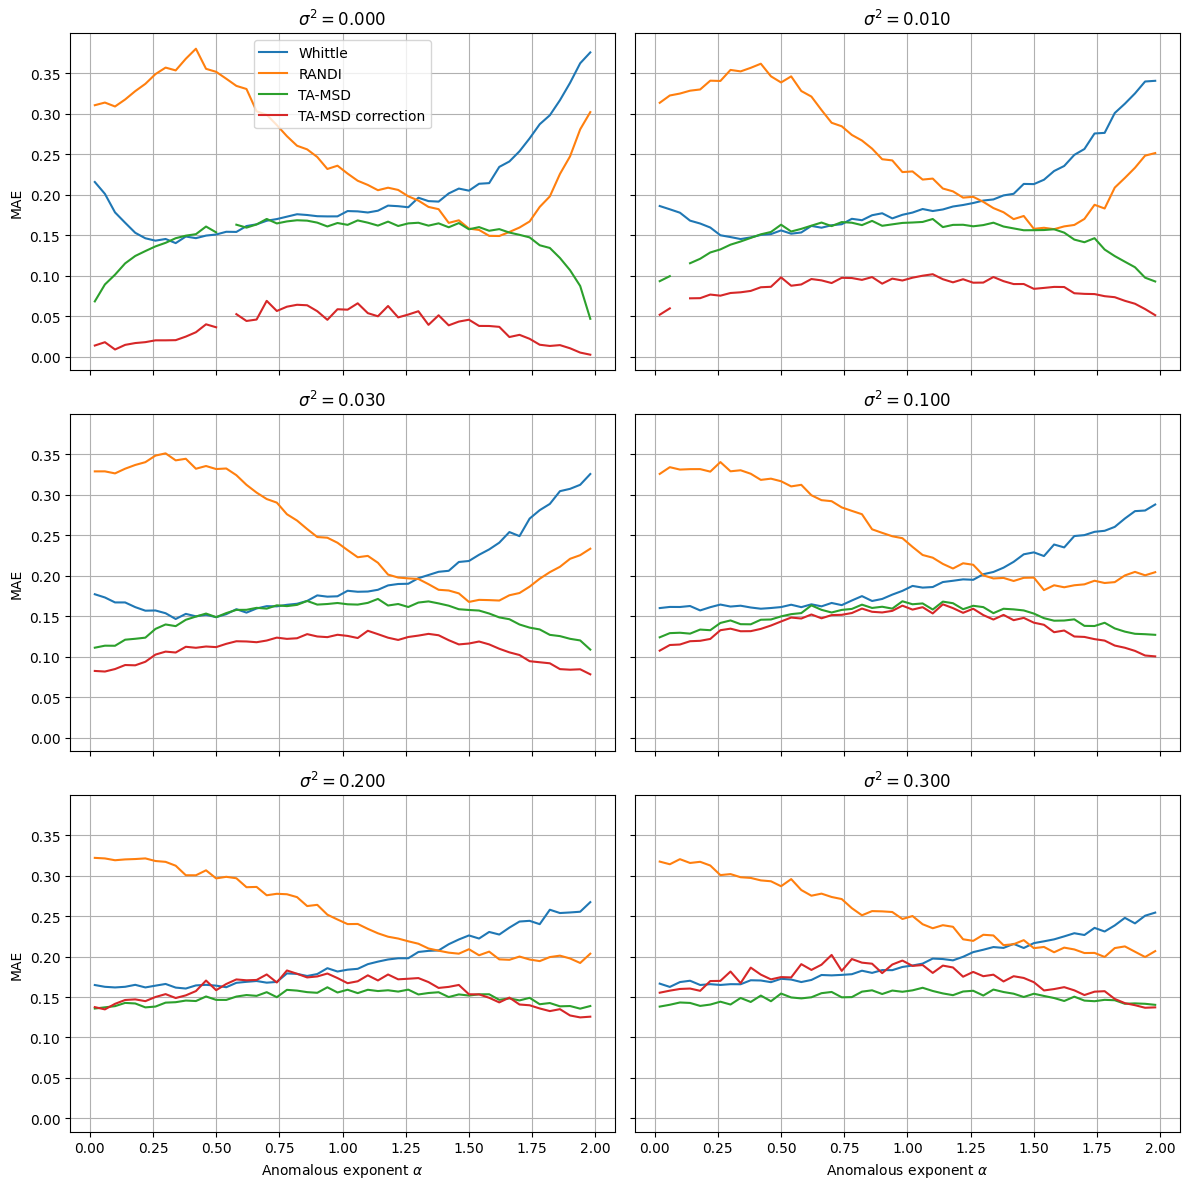

In [10]:
# ────────────────────── 1. Parameters ──────────────────────
HURST   = [i/100 for i in range(1, 100, 2)]          # 0.01 … 0.99
sigma   = [0, 0.01, 0.03, 0.1, 0.2, 0.3]          # 6 values of σ²
methods = ['Whittle', 'RANDI', 'TA-MSD', 'TA-MSD correction']

bs25    = randi25.layers[0].input_shape[-1]
T, N    = 25, 100                                # trajectory length

TFalpha      = TAMSDalpha(use_correction=False)  # TA-MSD
TFalphaTEA   = TAMSDalpha(use_correction=True)   # TA-MSD (correction)
models_class = models_phenom()

examples = 20        # ← now you can set any positive number

# ────────────────────── 2. Error array ──────────────────────
errs = np.zeros((len(sigma), len(HURST), len(methods)))

# ────────────────────── 3. Trajectory generation and MAE calculation ──────────────────────
for h_ind, hurst in enumerate(HURST):
    print(f'H = {hurst:.2f}')
    for _ in range(examples):
        D = 10**(np.random.random() * 12 - 6)                 # random diffusion coefficient
        
        for k, s2 in enumerate(sigma):
            cumts, lab = models_class.single_state(
                N=N, T=T, Ds=[D, D], alphas=[hurst * 2, s2]
            )
            ts  = (cumts[1:] - cumts[:-1]).transpose(1, 0, 2)  # displacements
            lab = lab[0, :, 0]                                 # true α values
            cumts = cumts.transpose(1, 2, 0)                   # [traj, dim, t]
            
            # ── RANDI method ──
            data25    = data_norm(cumts, dim=2, task=1)
            data_rs25 = data_reshape(data25, bs=bs25, dim=2)
            pred_25   = randi25.predict(data_rs25).flatten()
            cumts = cumts.transpose(0, 2, 1)
            
            # ── MAE for the four methods ──────────────────────
            mae_whittle  = np.mean([
                np.abs((whittle(sp[:, 0]) + whittle(sp[:, 1])) - lab_i)
                for sp, lab_i in zip(ts, lab)
            ])
            mae_randi    = np.mean(np.abs(pred_25 - lab))
            mae_tf       = np.mean(np.abs(TFalpha(cumts).numpy() - lab))
            mae_tf_tea   = np.mean(np.abs(TFalphaTEA(cumts).numpy() - lab))
            
            # ⬇️ accumulate errors (NOTE: '+=')
            errs[k, h_ind, :] += [mae_whittle, mae_randi, mae_tf, mae_tf_tea]

# ⬇️ average over the number of runs
errs /= examples

# ────────────────────── 4. Plotting 6 graphs (3×2) ──────────────────────
cmap   = plt.cm.get_cmap('tab10')
colors = {m: cmap(i) for i, m in enumerate(methods)}

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (ax, s2) in enumerate(zip(axes, sigma)):
    for m in methods:
        m_idx = methods.index(m)
        ax.plot(
            np.array(HURST) * 2,
            errs[idx, :, m_idx],
            label=m if idx == 0 else None,
            color=colors[m]
        )
    
    ax.set_title(rf'$\sigma^2 = {s2:.3f}$')
    ax.grid(True)
    if idx % 2 == 0:
        ax.set_ylabel('MAE')
    if idx // 2 == 2:
        ax.set_xlabel(r'Anomalous exponent $\alpha$')

# display legend only once
axes[0].legend()
plt.tight_layout()
plt.show()
